## VERIS 3000

Precision farming requires knownledge of clay and water content in three dimensions. Electrical resistivity is a sensible proxy parameter and can be determined by geoelectrical measurements.

One instrument is the VERIS 3000 with six wheel electrodes (distances are in cm):
![image](veris3000.jpg)

Potential is measured through the middle electrodes 3 and 4 with the spacing of

In [30]:
a = 0.114

Current is injected once through the outermost electrodes 1 and 6 forming a Schlumberger array, and once through the inner electrodes 2 and 5 forming a Wenner array.

        A1----2a----A2--a--M--a--N--a--B2----2a----B1

For the first case, AM=BN=3a and AN=BM=4a.
For the second case, AM=BN=a and AN=BM=2a.

The geometric factor is
$$ K = \frac{2\pi}{1/AM-1/BM-1/AN+1/BN} $$
and for a symmetric array (AM=BN and AN=BM).
$$ K = \frac{\pi}{1/AM-1/BM} $$
This is for the first array
$$ K = \frac{\pi}{1/3a-1/4a} = \frac{\pi}{4/12a-3/12a} = 12\pi a $$
and for the second array
$$ K = \frac{\pi}{1/a-1/2a} = \frac{\pi}{2/2a-1/2a} = 2\pi a $$
i.e. the voltage is six times higher.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer import pv
# %matplotlib notebook

In [32]:
data = ert.DataContainer()
data.createSensor([0, 0])
data.createSensor([2*a, 0])
data.createSensor([3*a, 0])
data.createSensor([4*a, 0])
data.createSensor([5*a, 0])
data.createSensor([7*a, 0])
data.createFourPointData(0, 0, 5, 2, 3)
data.createFourPointData(1, 1, 4, 2, 3)
print(data)
data["k"] = ert.geometricFactors(data)
print(data["k"]/np.pi/a)

Data: Sensors: 6 data: 2, nonzero entries: ['a', 'b', 'm', 'n', 'valid']
2 [12.0, 2.000000000000001]


The 1D sensitivity function for a pole-pole measurement is (Günther, 2004)
$$ s(z) = \frac{z}{\sqrt{a^2+z^2}^3} $$
and therefore for a four-electrode array
$$ s(z) = \frac{z}{\sqrt{AM^2+z^2}^3} - \frac{z}{\sqrt{BM^2+z^2}^3} - \frac{z}{\sqrt{AN^2+z^2}^3} + \frac{z}{\sqrt{BN^2+z^2}^3} $$
For a symmetric array this simplifies to
$$ s(z) = \frac{2z}{\sqrt{AM^2+z^2}^3} - \frac{2z}{\sqrt{BM^2+z^2}^3} $$

AM=0.3, zMax=0.20
AM=0.1, zMax=0.08


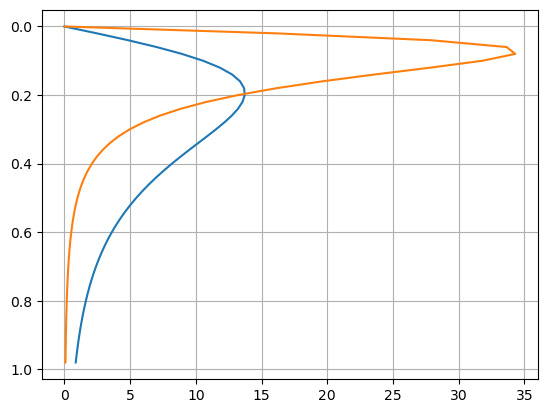

In [33]:
z = np.arange(0, 1.0, 0.02)
for fak in [3, 1]:
    am = fak * a
    bm = (fak+1) * a
    k = np.pi / (1/am - 1/bm)
    s = 2 * (z / np.sqrt(am**2+z**2)**3 - z / np.sqrt(bm**2+z**2)**3) * k
    plt.plot(s, z)
    print("AM={:.1f}, zMax={:.2f}".format(am, z[np.argmax(s)]))

plt.gca().invert_yaxis()
plt.grid()

An inversion using these two data as a mini-sounding is only possible for a two-layer with a fixed first layer thickness.

Next, we will have a look at the 2D sensitivity distribution.

Mesh: Nodes: 455 Cells: 408 Boundaries: 862


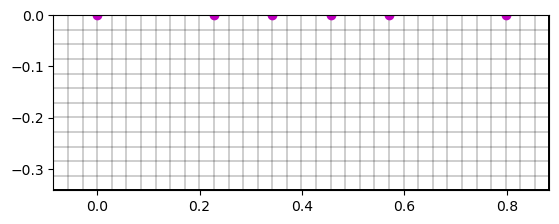

In [34]:
dx = a/4
mesh = mt.createGrid(x=np.arange(-3, 32)*dx,
                     y=np.arange(-12, 0.01)*dx)
print(mesh)
ax, _ = pg.show(mesh)
ax.plot(pg.x(data), pg.y(data), "mo")

In [35]:
fop = ert.ERTModelling(verbose=False)
fop.setData(data)
fop.setMesh(mesh)
model = pg.Vector(mesh.cellCount(), 1.0)
fop.createJacobian(model)

09/11/23 - 21:32:40 - pyGIMLi - INFO - Found 1 regions.
09/11/23 - 21:32:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
09/11/23 - 21:32:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
09/11/23 - 21:32:40 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1725 Cells: 1632 Boundaries: 1724


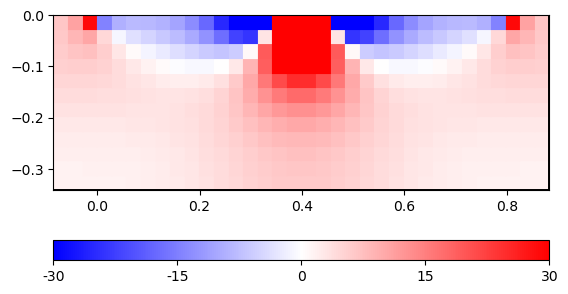

In [36]:
J = fop.jacobian()
kwargs = dict(cMap="bwr", cMin=-30, cMax=30)
ax, cb = pg.show(mesh, J[0]/mesh.cellSizes(), **kwargs)

The strongest (positive) sensitivity is between the potential electrodes. For the Schlumberger array, the zone reaches about 20cm deep. Anomalies in depths up to 10cm show a distinct footprint, whereas targets in greater depths show smoothed images.

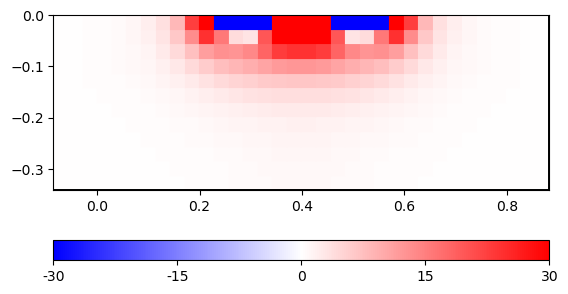

In [37]:
ax, cb = pg.show(mesh, J[1]/mesh.cellSizes(), **kwargs)

The general sensitivity structure of the Wenner array is similar, but reaches down not much more than 10cm. However, the footprint for targets at larger depth is smaller and anomalies are less smeared. Note that the sensitivity is already integrated over the perpendicular y direction, but a slice through the 3D sensitivity at y=0 is almost identical as there are the largest values. Note also that the 3D sensitivity of collinear arrays is rotational symmetric to the electrode line, i.e. the array is also sensitive within y=+/-10cm.